In [30]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [31]:
def getrealconc(t,x,y,D):
    blobcentre = np.array([t+10,t+20]) #1m/s
    blobsize = np.sqrt(2*2*D*(t+5))+10
    d = np.linalg.norm(np.array([x,y])-blobcentre)
    #v = d
    v = 300*norm(0,blobsize).pdf(d)
    return [t,t+10,x,y],v

In [32]:
X = []
Y = []
D = 0.01 #almost no diffusion
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            newX,newY = getrealconc(t,x,y,D)
            X.append(newX)
            Y.append(newY)
X = np.array(X)
Y = np.array(Y)
#Y /= np.std(Y)

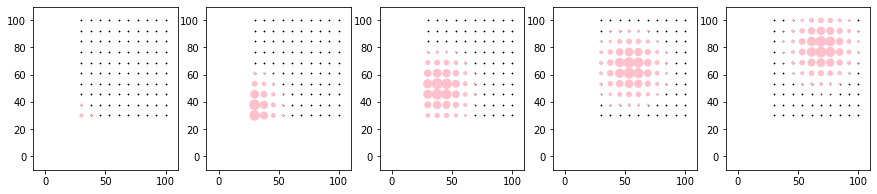

In [33]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [34]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [41]:
#set up our model...
N_feat = 2000 #Number of features used to infer the source
k = EQ(30, 1)
res = [300,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference

In [42]:
#maybe this is the sort of equivalent to the number of upcrossings in 3d?
#the number of fourier features is going to need to be of this order presumably?
np.prod(np.array(boundary[1])-np.array(boundary[0]))/(k.l2*np.pi)

12200.56328951575

In [43]:
mInfer.computeModelRegressors(Nparticles=5) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
#sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
#concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


In [45]:
mInfer.coords = mInfer.coords[:,::5,::3,::3]
concmean,concvar = mInfer.computeConcentration(meanZ,covZ,Nsamps=6,Nparticles=5)

Initialising particles...
Diffusing particles...


In [73]:
gridps = mInfer.coords.transpose([1,2,3,0]).copy()
realconc = np.zeros(mInfer.coords.shape[1:])
for i in np.ndindex(gridps.shape[:3]):
    _,v= getrealconc(gridps[i][0],gridps[i][1],gridps[i][2],D)
    realconc[i]=v

<ipython-input-31-06e0b88ded5c>:3: RuntimeWarning: invalid value encountered in sqrt
  blobsize = np.sqrt(2*2*D*(t+5))+10


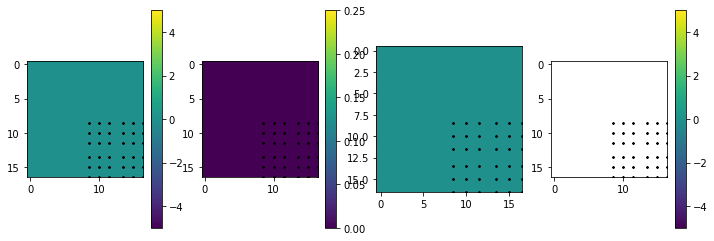

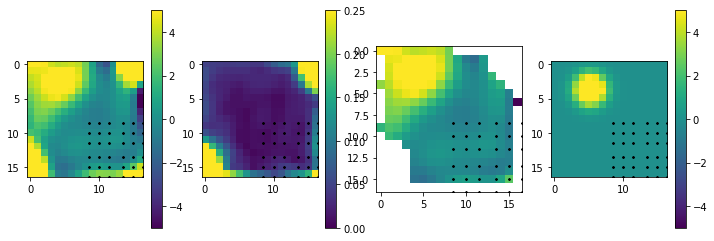

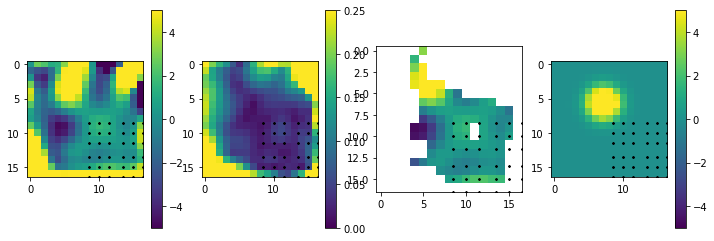

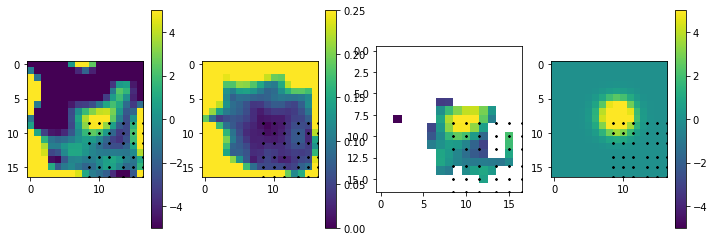

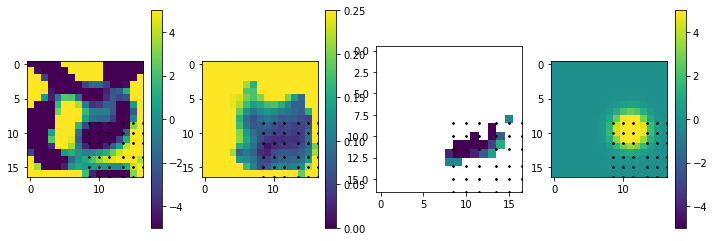

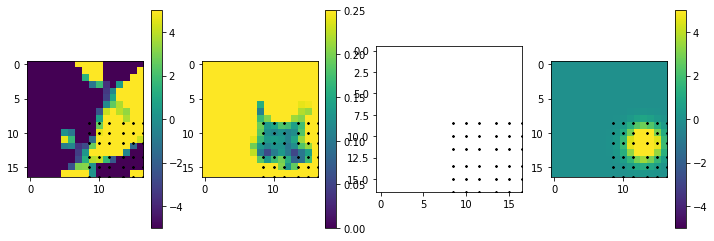

In [74]:
gridX = mInfer.getGridCoord(X[:,1:])/np.array([5,2,2])

for tsamp in range(0,mInfer.coords.shape[1],2):
    plt.figure(figsize=[12,4])
    plt.title(tsamp)
    plt.subplot(1,4,1)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(concmean[tsamp,:,:])
    plt.clim([-5,5])
    plt.colorbar()
    plt.subplot(1,4,2)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(np.sqrt(concvar[tsamp,:,:]))
    plt.clim([0,0.25])
    plt.colorbar()
    plt.subplot(1,4,3)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    vals = concmean[tsamp,:,:]
    alphas = np.sqrt(concvar[tsamp,:,:])<0.05
    plt.imshow(vals,alpha=alphas.astype(float))
    plt.clim([-5,5])
    
    plt.subplot(1,4,4)
    plt.scatter(gridX[:,1],gridX[:,2],1,color='black')
    plt.imshow(realconc[tsamp,:,:])    
    plt.clim([-5,5])
    plt.colorbar()
    
    #t = ts[tsamp*10]
    #plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]*5,color='red')
    #